# Binary Classification of COVID-19 X-rays with Transfer Learning

Building on top of VGG-16 architecture

## Data 

File structure is as follows:

|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>

NOTE: Notebook is formatted for Colab


## Binary Classification: COVID-19 vs. Normal

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

print('done')

done


#### Load Image Data

In [3]:
# Mounting Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
DATA_LIST = os.chdir("/content/drive/MyDrive/Challenge/Covid_Data_GradientCrescent/two/train")
DATASET_PATH  = "/content/drive/MyDrive/Challenge/Covid_Data_GradientCrescent/two/train"
TEST_DIR =  '/content/drive/MyDrive/Challenge/Covid_Data_GradientCrescent/two/test'

# Input Parameters + Hyperparameters
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0001 

print('done')

done


#### Generate Training and Validation Batches

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

print('done')
print(valid_batches)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
done


In [ ]:
# Testing

# print((train_batches[0][0])) # Each image is 224x224 pixels, ordered in batches of 10 (default)

# General Information about Dataset

# 104 Training Images (80% of total), 26 Validation images (20% of total)

# Data structure: Tuple

# First index: Batches (Size 10 by default)
# Second index: Set of images vs Class (1 or 0)
# Third index: Image RGB (224x224x3px each) --> 0 for R, 1 for G, 2 for B

# train_data = train_batches[1] # How to separate train data from labels??
# # print(train_batches[1][1])
# labels = []
# labels = np.array(labels)
# data = []
# data = np.array(data)

# for j in range(len(train_batches)):
#     labels = np.append(labels, np.array(train_batches[j][1]))
#     data = np.append(data, np.array(train_batches[j][0]))
    
# print(labels.shape)
# print(data.shape)



(104,)
(15654912,)


In [11]:
# Loading VGG-16 architecture and weights trained for ImageNet

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_batches[0][0][0].shape)
base_model.trainable = False ## Not trainable weights
base_model.summary()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
# Preprocessing Input Datasets

for batchNo in np.arange(10):
    for imgNo in np.arange(10):
        if train_batches[batchNo][0][imgNo] is not None:
            train_batches[batchNo][0][imgNo] = preprocess_input(train_batches[batchNo][0][imgNo])
            
for batchNo in np.arange(3):
    if batchNo != 2:
        for imgNo in np.arange(10):
            if valid_batches[batchNo][0][imgNo] is None:
                break
            else:
                valid_batches[batchNo][0][imgNo] = preprocess_input(valid_batches[batchNo][0][imgNo])
    else:
        for imgNo in np.arange(6):
            valid_batches[batchNo][0][imgNo] = preprocess_input(valid_batches[batchNo][0][imgNo])
    
print('done')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


done


#### Build Model

In [13]:
from keras import layers, models

flatten1 = layers.Flatten()
dense1 = layers.Dense(256, activation='sigmoid')
predL = layers.Dense(1, activation='sigmoid')
batchNorm = layers.BatchNormalization()


model = models.Sequential([
    

    base_model,
    flatten1,
    batchNorm,
    dense1,
    predL,
])

model.summary()                                                           

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,238,081
Trainable params: 6,473,217
Non-trainable params: 14,764,864
____________________________________

#### Train Model

In [14]:
#FIT MODEL

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(train_batches, epochs=NUM_EPOCHS, validation_data=valid_batches, batch_size=BATCH_SIZE, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 20s 751ms/step - loss: 0.5263 - accuracy: 0.7128 - val_loss: 0.4767 - val_accuracy: 0.9000
Epoch 2/40
10/10 [==============================] - 6s 573ms/step - loss: 0.3641 - accuracy: 0.8936 - val_loss: 0.3796 - val_accuracy: 1.0000
Epoch 3/40
10/10 [==============================] - 6s 609ms/step - loss: 0.2972 - accuracy: 0.8936 - val_loss: 0.3452 - val_accuracy: 0.9000
Epoch 4/40
10/10 [==============================] - 6s 579ms/step - loss: 0.2726 - accuracy: 0.8723 - val_loss: 0.3178 - val_accuracy: 0.9500
Epoch 5/40
10/10 [==============================] - 6s 564ms/step - loss: 0.2403 - accuracy: 0.8723 - val_loss: 0.2594 - val_accuracy: 0.9500
Epoch 6/40
10/10 [==============================] - 6s 570ms/step - loss: 0.2194 - accuracy: 0.9255 - val_loss: 0.3044 - val_accuracy: 0.9000
Epoch 7/40
10/10 [==============================] - 6s 566ms/step - loss: 0.2246 - accuracy: 0.9362 - val_loss: 0.3087 - val_accuracy: 0.9000
Epoch 8/40
10/10

####  Plot Accuracy and Loss During Training

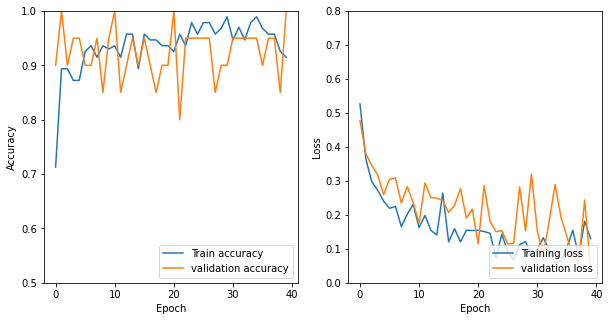

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

ax = plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.8])
plt.legend(loc='lower right')


#### Plot Test Results

Found 18 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


18/18 [==============================] - 9s 482ms/step
covid/nejmoa2001191_f3-PA.jpeg


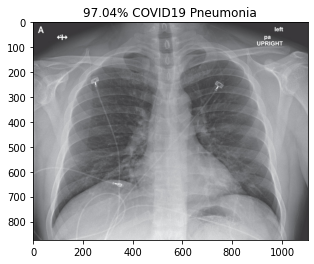

covid/nejmoa2001191_f4.jpeg


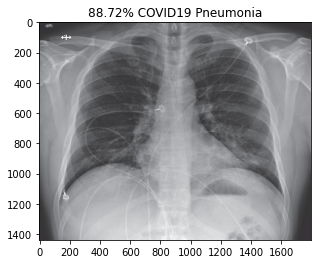

covid/nejmoa2001191_f5-PA.jpeg


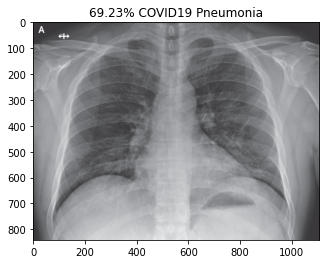

covid/radiol.2020200490.fig3.jpeg


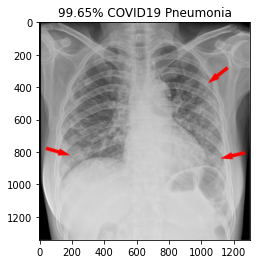

covid/ryct.2020200028.fig1a.jpeg


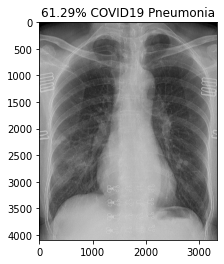

covid/ryct.2020200034.fig2.jpeg


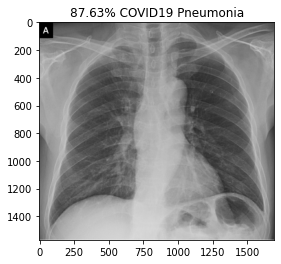

covid/ryct.2020200034.fig5-day0.jpeg


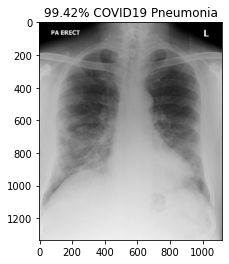

covid/ryct.2020200034.fig5-day4.jpeg


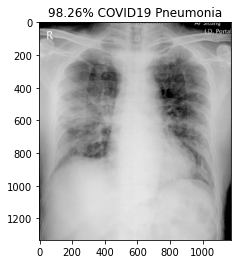

covid/ryct.2020200034.fig5-day7.jpeg


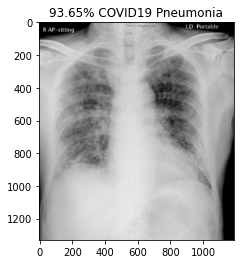

normal/NORMAL2-IM-1385-0001.jpeg


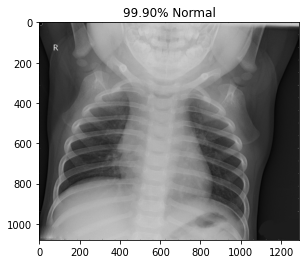

normal/NORMAL2-IM-1396-0001.jpeg


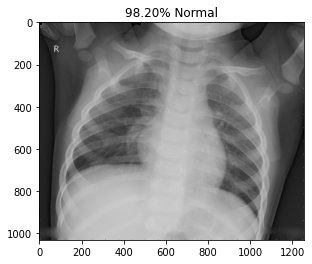

normal/NORMAL2-IM-1400-0001.jpeg


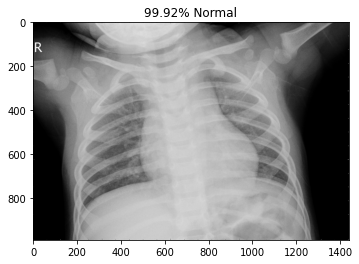

normal/NORMAL2-IM-1401-0001.jpeg


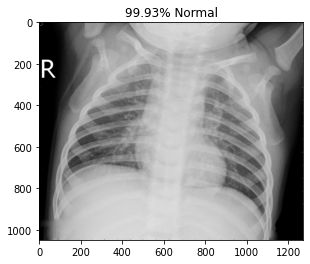

normal/NORMAL2-IM-1406-0001.jpeg


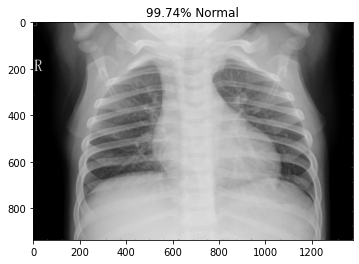

normal/NORMAL2-IM-1412-0001.jpeg


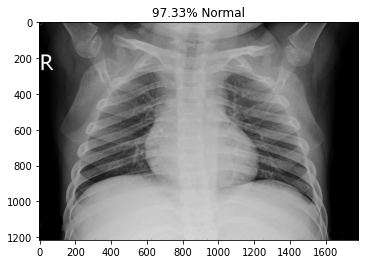

normal/NORMAL2-IM-1419-0001.jpeg


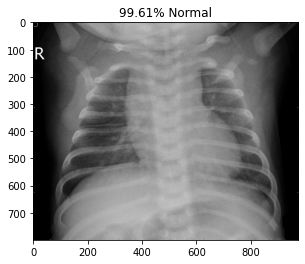

normal/NORMAL2-IM-1422-0001.jpeg


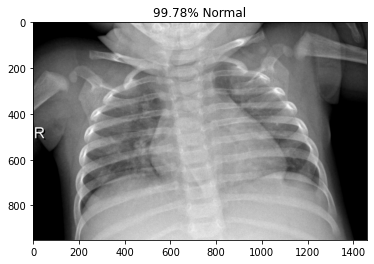

normal/NORMAL2-IM-1423-0001.jpeg


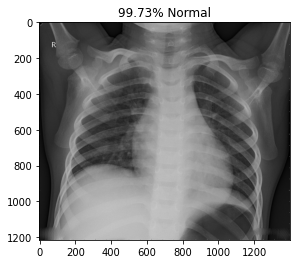

In [17]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [ ]:
loss, acc = model.evaluate(eval_generator, batch_size=18,verbose=1) # Shows 100% accuracy on testing data, much different than results from images above

18/18 [==============================] - 7s 369ms/step - loss: 0.3467 - accuracy: 1.0000


In [ ]:
print(loss)
print(acc)

0.34672626852989197
1.0


## TSNE Plot

Extracting features from a fully-connected layer using t-SNE to reduce the dimensionality of extracted features to 2 dimensions.

In [19]:
# Converting data to arrays
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")


imgs = np.zeros([130, 224, 224, 3])
labels = np.zeros([130, 1])
count = 0

print('Data Prep')

for img, label in tsne_data_generator:
    if count == 130:
        break
    imgs[count] = img
    labels[count] = label
    count+= 1

print('TSNE Running')

features = intermediate_layer_model.predict(imgs)
tsne = TSNE(n_components=2).fit_transform(features)

print('TSNE Done')

tx = tsne[:, 0]
ty = tsne[:, 1]

Found 130 images belonging to 2 classes.
Data Prep
TSNE Running


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


TSNE Done


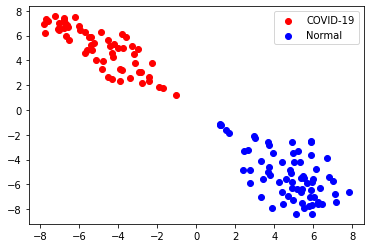

In [20]:
# Plotting t-SNE (2 Components)

colors = ['red', 'blue']

fig = plt.figure()
ax = fig.add_subplot(111)

COVIDX = []
COVIDY = []
NormalX = []
NormalY = []

for i in np.arange(labels.shape[0]):
    if labels[i] == 0:
        COVIDX.append(tx[i])
        COVIDY.append(ty[i])
    else:
        NormalX.append(tx[i])
        NormalY.append(ty[i])
        
ax.scatter(COVIDX, COVIDY, c='red', label='COVID-19')
ax.scatter(NormalX, NormalY, c='blue', label = 'Normal')

ax.legend(loc='best') # How to display legend?
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->